# Gerekli Kütüphanelerin İmportlanması

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


# Veri Setinin Okunması

In [3]:
df = pd.read_csv("veriler.csv")

# Veri Setinin Etiketlerinin Sayısallaştırılması 

In [4]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])  # Adult=0, Non_Adult=1 gibi


# Veri Setinin Görüntülenmesi

In [5]:
df

,Description,Category,label
0,Washington Correspondent New York Magazine Wri...,Non_Adult,1
1,Host of NPR s Pop Culture Happy Hour Author NY...,Non_Adult,1
2,Gay Men Ring Free gay tube for mature gay men ...,Adult,0
3,SeeMomSuck is packed with the best Amateur Ste...,Adult,0
4,xReview com provides in depth porn site review...,Adult,0
...,...,...,...
845,Free downloads of mobile porn in 3gp mp4 video...,Non_Adult,1
846,Your Daily Girls features new porn galleries u...,Non_Adult,1
847,Tweeting breaking news from CTVNews ca in the ...,Adult,0
848,Political editor Nine News Co author of The Ma...,Adult,0


# Category sütununun silinmesi

In [6]:
df = df.drop(columns=["Category"])


# Son Veri Seti

In [7]:
df

,Description,label
0,Washington Correspondent New York Magazine Wri...,1
1,Host of NPR s Pop Culture Happy Hour Author NY...,1
2,Gay Men Ring Free gay tube for mature gay men ...,0
3,SeeMomSuck is packed with the best Amateur Ste...,0
4,xReview com provides in depth porn site review...,0
...,...,...
845,Free downloads of mobile porn in 3gp mp4 video...,1
846,Your Daily Girls features new porn galleries u...,1
847,Tweeting breaking news from CTVNews ca in the ...,0
848,Political editor Nine News Co author of The Ma...,0


In [8]:
empty_rows = df.isnull().all(axis=1)
empty_cols = df.isnull().all(axis=0)

if empty_rows.any() == False:
   print("Boş satır yok!")
if empty_cols.any() == False:
   print("Boş sütun yok!")



Boş satır yok!
Boş sütun yok!


# LSTM

# Neden?

    Modeller sayısal veri ile çalışır, doğrudan metin (string) verisini anlayamaz.

    Metinler farklı uzunluklarda olur, ama modeller genellikle sabit uzunlukta giriş ister.

    Bu yüzden metinleri önce kelimelere ayırıp sayılara dönüştürürüz, sonra hepsini aynı uzunlukta dizilere tamamlarız.

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Description"])

sequences = tokenizer.texts_to_sequences(df["Description"])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post') # sonuna ekleme ve kesme = post

X = padded
y = df["label"].values


# Neden yapıyoruz?

    Modeli eğitmek (train) ve değerlendirmek (test) için farklı veri kümeleri kullanmak gerekiyor.

    Eğer aynı verilerle hem eğitirsek hem sınarsak, model sadece gördüğü verileri "ezberler", gerçek hayatta ne kadar iyi olacağını anlayamayız.

    Test seti, modelin gerçek performansını ölçmek için ayrılır.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Neden bu modeli kurduk?

    Metin verisini anlamlı vektörlere dönüştürmek için Embedding kullandık.

    Metin sıralarının içindeki kelime ilişkilerini öğrenmek için LSTM ile bağlam yakaladık.

    İkili sınıflandırma çıktısı için uygun sigmoid aktivasyonlu Dense katmanla sonucu tahmin ettik.

    Modeli, uygun kayıp fonksiyonu ve optimizer ile derleyerek eğitim için hazır hale getirdik.

In [11]:
model = Sequential() # Katmanları ardaşık olarak ekler

# input_dim=5000: Modelimiz, en sık kullanılan 5000 farklı kelimeyi tanıyacak. Yani kelime sayımız 5000 tane.

# output_dim=64: Her kelime, 64 tane sayıdan oluşan özel bir vektörle temsil edilecek. Bu vektör, kelimenin anlamını yansıtan sayısal bir “özellik kümesi” gibi düşünülebilir.

# input_length=100: Modelimize giren her cümle ya da metin 100 kelimelik sabit uzunlukta olacak (eksikse sıfır ile tamamlandı, fazlaysa kesildi).


model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))

# LSTM (Long Short-Term Memory):
# Metin gibi sıralı verilerde, kelimelerin zaman içinde nasıl bağlandığını ve birbirini nasıl etkilediğini öğrenen özel bir yapay sinir ağı katmanı.
# Yani, önceki kelimelerle ilgili önemli bilgileri “hatırlayıp” sonraki kelimeler için kullanır.

# 64:
# Bu LSTM katmanının içinde 64 tane nöron (hücre) var. Yani katman, girdi dizisini 64 boyutlu bir özellik vektörüne dönüştürür.

# dropout=0.2:
# Eğitim sırasında aşırı öğrenmeyi (overfitting) önlemek için, bu katmanın girişindeki bağlantıların %20’si rastgele kapatılır. Bu sayede model daha sağlam öğrenir.

# recurrent_dropout=0.2:
# LSTM katmanının kendi içindeki zaman serisi bağlantılarında (geri besleme bağlantıları) da aynı şekilde %20 oranında dropout uygulanır.

model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# Dense(1):
# Modelin sonuna bir tane tam bağlı (dense) katman ekliyoruz.
# Bu katman sadece 1 nörondan oluşuyor.

# activation='sigmoid':
# Bu nöronun çıkışı, sigmoid aktivasyon fonksiyonuyla 0 ile 1 arasında bir değer olacak.
# Yani, çıktı olasılık olarak yorumlanabilir.
model.add(Dense(1, activation='sigmoid'))



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Early Stopping için parametrelerin belirlenmesi

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',       # izlenecek metrik
    patience=200,               # iyileşme olmadan kaç epoch beklesin?
    restore_best_weights=True # en iyi ağırlıkları geri yükle
)


# Modelin Eğitilmesi

In [39]:
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)



Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8091 - loss: 0.4667 - val_accuracy: 0.8500 - val_loss: 0.4106
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7983 - loss: 0.4764 - val_accuracy: 0.8000 - val_loss: 0.4600
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6575 - loss: 0.6102 - val_accuracy: 0.5833 - val_loss: 0.6817
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6054 - loss: 0.6799 - val_accuracy: 0.5833 - val_loss: 0.6797
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5933 - loss: 0.6740 - val_accuracy: 0.5833 - val_loss: 0.6795
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5961 - loss: 0.6752 - val_accuracy: 0.5833 - val_loss: 0.6805
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6232 - loss: 0.6639 - val_accuracy: 0.5833 - val_loss: 0.6802
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5850 - loss: 0.6823 - val_accu

# Eğitim Doğruluğu : % 83.03
# Test Doğruluğu : % 81.18

In [40]:
losstest, acctest = model.evaluate(X_test, y_test)
losstrain, acctrain = model.evaluate(X_train, y_train)
acctrain*=100
acctest*=100
print(f"Eğitim Doğruluğu : % {acctrain:.2f}")
print(f"Test Doğruluğu : % {acctest:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7789 - loss: 0.5048
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8107 - loss: 0.4569
Eğitim Doğruluğu : % 82.52
Test Doğruluğu : % 81.57


| Belirti                                             | Var mı? | Açıklama                                                                                               |
| --------------------------------------------------- | ------- | ------------------------------------------------------------------------------------------------------ |
| Eğitim doğruluğu yüksek, doğrulama doğruluğu düşük  | ✅ Evet  | %84 vs %73 farkı var. Bu, modelin eğitim verisine fazla uyum sağladığını (ezberlediğini) gösterebilir. |
| Doğrulama doğruluğu zamanla düşüyor mu?             | ❌ Hayır | Doğrulama doğruluğu sabit ya da hafif artıyor; bu da overfitting’in çok ciddi olmadığını gösteriyor.   |
| Eğitim doğruluğu artarken doğrulama doğruluğu sabit | ✅ Evet  | Bu da klasik bir overfitting işareti olabilir.                                                         |


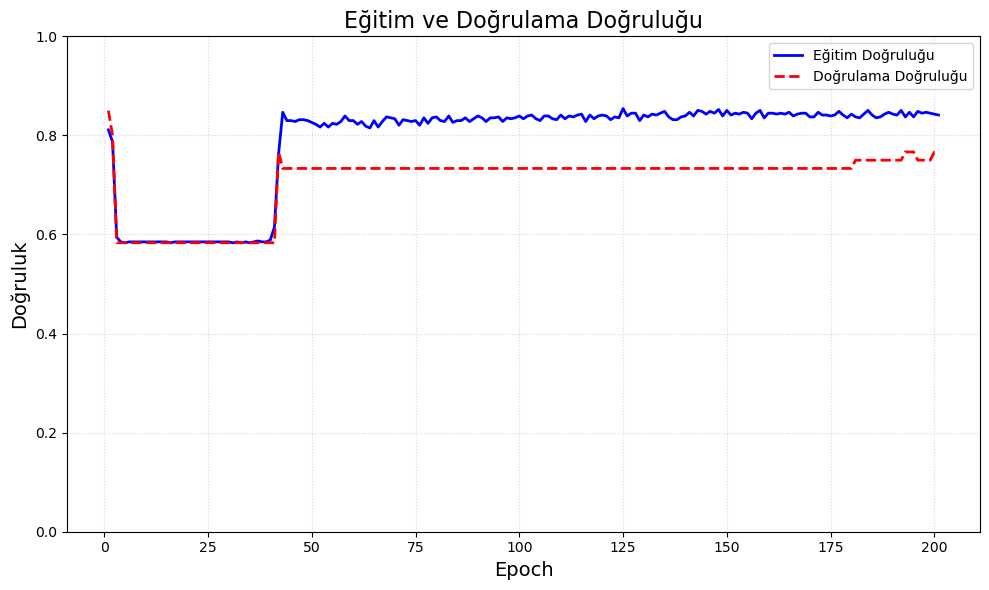

In [41]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, acc, label='Eğitim Doğruluğu', color='blue', linewidth=2)
plt.plot(epochs, val_acc, label='Doğrulama Doğruluğu', color='red', linewidth=2, linestyle='--')

plt.title('Eğitim ve Doğrulama Doğruluğu', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Doğruluk', fontsize=14)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


In [47]:
y_scores = model.predict(X_test).flatten()  # Olasılıkları al, array'i 1D yap


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [48]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal eşik değeri: {optimal_threshold}")


Optimal eşik değeri: 0.8965544700622559


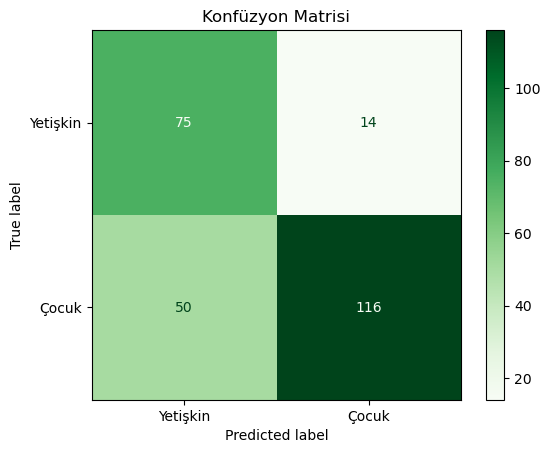

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
labels = ['Yetişkin', 'Çocuk']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Greens)
plt.title("Konfüzyon Matrisi")
plt.grid(False)
plt.show()


In [51]:
import json
from tensorflow.keras.models import load_model

# Model ve tokenizer'ı kaydetmek için
output_dir = "./results"
model.save(f"{output_dir}/model.h5")

# Tokenizer'ı JSON formatında kaydet
tokenizer_json = tokenizer.to_json()
with open(f"{output_dir}/tokenizer2.json", "w", encoding='utf-8') as f:
    f.write(tokenizer_json)


# --------------------------------------------
# Kaydedilen modeli ve tokenizer'ı yüklemek için
loaded_model = load_model(f"{output_dir}/model.h5")

from tensorflow.keras.preprocessing.text import tokenizer_from_json

with open(f"{output_dir}/tokenizer2.json", "r", encoding='utf-8') as f:
    tokenizer_json = f.read()
loaded_tokenizer = tokenizer_from_json(tokenizer_json)
